In [354]:
import __init__

In [355]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [419]:
# Load external librairies
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

# Load internal librairies
from fleming_lib.dataset import create_dataset
from fleming_lib.severity_scores import compute_sapsii_score
from fleming_lib.utils import add_categories

from fleming_lib.metrics import add_target, add_age


In [420]:
# Open a connection to OMOP
from fleming_lib.tools import connect_to_omop
conn = connect_to_omop()

In [421]:
import time
import warnings

from fleming_lib.metrics import add_rolling_avg, add_target, add_super_target, add_age
from fleming_lib.utils import to_categorical, to_onehot, to_numeric, convert_frac, add_categories, add_missing_columns, check_length

def create_dataset(list_patients, n_patients_per_batch=10, verbose=False):
    """Create list of dataset given a list of patients.
    
    Parameters
    ----------
    list_patients : list of int
        List of patients ID.
    n_patients_per_batch : int (default=10)
        Number of patients to sequentially load data for, in order not to cause timeout if the query is too long to
        process by the server.
    verbose : bool (default=False)
        Verbosity level.
    
    Returns
    -------
    dataset : pd.DataFrame
        Dataset containing all data associated to each patient.
        
    """
    t0 = time.time()
    frame = []
    
    if not isinstance(list_patients, list):
        list_patients = [list_patients]
        
    n_patients = len(list_patients)
    
    # Extract meta data
    # -----------------
    if verbose:
        msg = 'Extracting meta data...'
        delta_t = str(int(time.time() - t0)) + ' s'
        print('{:100s} [{:10s}]'.format(msg, delta_t), end='\r')
            
    query = """     
    
        select 
            distinct p.person_id, p.gender_source_value gender, p.race_source_value race, p.birth_datetime 
        from person p
        
        ;"""
    print('   start meta...        ', end='\r')
    meta = pd.read_sql_query(query, conn)
    print('...end meta            ', end='\r')
    # Dictionary containing unique categories for each categorical variable
    categories = dict()
    
    # Convert categorical variable to 'categorical' type
    categorical_variables = ['gender', 'race']
    # Extracting categories for each categorical variable
    categories = add_categories(categories, meta, categorical_variables)
    
    meta = to_categorical(meta, categorical_variables, categories)
    meta = to_onehot(meta, categorical_variables)
    # One-hot column names
    meta_names = meta.columns
    
    # Extract unique measurements values from categorical variables
    # (here 'Heart rate rhythm' and 'Admission Type')
    query = """
        select
            distinct m.measurement_concept_name, m.value_source_value
        from 
            measurement m 
        where
            m.measurement_concept_id in
            (3022318   -- heart_rhythm
            )
        order by
            m.measurement_concept_name, m.value_source_value     
        ;"""

    unique_categ_values = pd.read_sql_query(query, conn)
    categorical_variables = ['Heart rate rhythm']
    # Adding categories of each categorical variables to dict 'categories'
    for var in categorical_variables:
        tmp = unique_categ_values.loc[unique_categ_values.measurement_concept_name == var]
        tmp.drop('measurement_concept_name', axis=1, inplace=True)
        tmp.rename(index=str, columns={'value_source_value': var}, inplace=True)
        categories = add_categories(categories, tmp, var)
    
    # Create sublist of patients (batch)
    n_iter = int(n_patients / n_patients_per_batch)
    sublists_patients = [list_patients[i: i+n_patients_per_batch]
                         for i in range(0, n_patients, n_patients_per_batch)]
    n_sublists = len(sublists_patients)
    
    # Extracting data for each patient
    for i, sublist_patients in enumerate(sublists_patients):
        if verbose:
            base_msg = 'Batch {}/{}'.format(i+1, n_sublists)
            msg = base_msg
            delta_t = str(int(time.time() - t0)) + ' s'
            print('{:100s} [{:10s}]'.format(msg, delta_t), end='\r')
        
        # Extract measures
        # ----------------
        if verbose:
            add_msg = 'Extracting measures...'
            msg = base_msg + ' - ' + add_msg
            delta_t = str(int(time.time() - t0)) + ' s'
            print('{:100s} [{:10s}]'.format(msg, delta_t), end='\r')
            
        if len(sublist_patients) == 1:
            match_person = "m.person_id = {}".format(sublist_patients[0])
        else:
            match_person = "m.person_id in {}".format(tuple(sublist_patients))
            
        query = """ 
        with icustays as
        ( 

        select person_id
        from visit_detail
        where visit_detail_concept_id = 581382              
        and visit_type_concept_id = 2000000006 

        ) ,

        surgflag as
        (
          select icustays.person_id as person_id
            , case when c.concept_id  = 4149152 then 1 else 0 end as surgical
            , row_number() over
            (
              partition by icustays.person_id
              order by vd.visit_start_datetime
            ) as serviceOrder

          from icustays
          left join visit_detail vd
              on icustays.person_id = vd.person_id 

          left join concept c
              on c.concept_id = vd.visit_detail_concept_id 

          where vd.visit_type_concept_id = 45770670   -- 'Services and care'

        ) ,

        admissions_icu as (

        select 
            icustays.person_id as person_id,
            vd.visit_detail_id visit_detail_id,
        case
                  when c.concept_id  = 4149152 and v.visit_source_value = 'ELECTIVE' -- and sf.surgical = 1
                  -- c.concept_id is for 'Surgical service' and v.visit_source_value for 'Scheduled' ones
                      then 'ScheduledSurgical'

                  when c.concept_id  = 4149152 and (v.visit_source_value = 'EMERGENCY' or v.visit_source_value = 'URGENT') -- and sf.surgical = 1
                  -- c.concept_id is for 'Surgical service' and v.visit_source_value for 'Unscheduled' ones
                      then 'UnscheduledSurgical'

                  when c.concept_id  = 45763735 -- General medical service 
                      then 'Medical'

                  else 'No matching found' 
                  
        end as admission_type

        from icustays

        left join visit_detail vd
            on icustays.person_id = vd.person_id 

        left join concept c
            on c.concept_id = vd.visit_detail_concept_id   

        left join visit_occurrence v            -- WHEN ADDED,number_icu_general_medical = 112 370 ---> 697 338 !
            on icustays.person_id = v.person_id

        -- left join surgflag sf
        --    on icustays.person_id = sf.person_id and sf.serviceOrder = 1

        where vd.visit_type_concept_id = 45770670   -- 'Services and care', maybe redondant.. 

        )    
        
            
        select
            distinct m.person_id, m.measurement_datetime, m.measurement_concept_name, m.value_source_value, 
            m.unit_source_value, d.death_datetime, adm_icu.admission_type admission_type
        
        from 
            measurement m
        left join 
            admissions_icu adm_icu on m.visit_detail_id = adm_icu.visit_detail_id
        left join 
            death d on d.person_id = m.person_id
            
        where
            measurement_concept_id IN
            (3022318,   -- heart_rhythm
             3024171,   -- respiratory_rate
             3028354,   -- vent_settings
             3012888,   -- diastolic_bp
             3027598,   -- map_bp
             3004249,   -- systolic_bp
             3027018,   -- heart_rate
             3020891,   -- temperature
             3016502,   -- spo2
             3020716,   -- fio2
             3032652,   -- glasgow coma scale
             
             -- chemicals
             3019550,   -- sodium serum/plasma (en) | natremie (fr)
             3023103,   -- potassium serum/plasma (en) | kaliemie (fr)
             3024128,   -- bilirubin
             
             -- hemato
             3003282    -- Leukocytes [#/volume] in Blood by Manual count
             
            )
        and {}
        order by measurement_datetime
            ;""".format(match_person)
        
        df = pd.read_sql_query(query, conn)
        
        # Check if data is empty for a patient
        check_length(df)

        if verbose:
            add_msg = 'Formatting data...'
            msg = base_msg + ' - ' + add_msg
            delta_t = str(int(time.time() - t0)) + ' s'
            print('{:100s} [{:10s}]'.format(msg, delta_t), end='\r')

        df['death_datetime'] = pd.to_datetime(df['death_datetime'])
        df['measurement_datetime'] = pd.to_datetime(df['measurement_datetime'])
        
        # Add target: patient's death' status, relative to the measurement datetime (target) and to the hospital stay (super_target)
        df = df.groupby('person_id').apply(add_target)
        df = df.groupby('person_id').apply(add_super_target)
        
        # Convert to timeseries matrix
        df = df.pivot_table(index= ['measurement_datetime','target','super_target','person_id', 'admission_type'], 
                            columns='measurement_concept_name', values='value_source_value', aggfunc='first')
        df.reset_index(inplace=True)
        df.columns.name = None
        
        
        # Convert types
        # -------------
        # Convert to numerical
        numerical_variables = ['BP diastolic', 'BP systolic', 'Body temperature', 'Heart rate', 'Mean blood pressure',
                               'Glasgow coma scale', 'Oxygen concentration breathed', 
                               'Mean pressure Respiratory system airway Calculated', 
                               'Oxygen saturation in Arterial blood', 'Respiratory rate',
                               'Leukocytes [#/volume] in Blood by Manual count',
                               'Potassium serum/plasma', 'Sodium serum/plasma', 'Total Bilirubin serum/plasma']
           
        df = add_missing_columns(df, numerical_variables)
    
        df = convert_frac(df, numerical_variables)
        df = to_numeric(df, numerical_variables)
        
        # Convert to categorical and one-hot encode
        categorical_variables = ['Heart rate rhythm', 'admission_type']
        
        df = add_missing_columns(df, categorical_variables)
        
        df = to_categorical(df, categorical_variables, categories)
        df = to_onehot(df, categorical_variables)
        
        
        # Add meta data to measures
        # -------------------------
        if verbose:
            add_msg = 'Adding meta data...'
            msg = base_msg + ' - ' + add_msg
            delta_t = str(int(time.time() - t0)) + ' s'
            print('{:100s} [{:10s}]'.format(msg, delta_t), end='\r')
            
        df = pd.merge(df, meta, how='inner', on='person_id')
        
        # Add additional features
        # -----------------------
        if verbose:
            add_msg = 'Adding additional features...'
            msg = base_msg + ' - ' + add_msg
            delta_t = str(int(time.time() - t0)) + ' s'
            print('{:100s} [{:10s}]'.format(msg, delta_t), end='\r')
        
        # - age
        df = df.groupby('person_id').apply(add_age, round_to_dec=1)
        # - 2h rolling average respiratory rate
        df = df.groupby('person_id').apply(add_rolling_avg, column='Respiratory rate', window=2)
        
        frame.append(df)
        
        if verbose:
            add_msg = 'Done'
            msg = base_msg + ' - ' + add_msg
            delta_t = str(int(time.time() - t0)) + ' s'
            print('{:100s} [{:10s}]'.format(msg, delta_t), end='\r')
            print('')
            
    # Concat dataframes
    dataset = pd.concat(frame)
    dataset = dataset.reindex_axis(frame[0].columns, axis=1)
    
    return dataset

In [422]:
# Define list of patients
single_id = 62063368
list_patients = [62063368, 62063384, 62063393]

# Create dataset
dataset = create_dataset(list_patients, verbose=True, n_patients_per_batch=10)

/Users/jeremydesir/Desktop/DataForGood/batch4_diafoirus_fleming/fleming_lib/utils.py:257: UserWarning: Colmun `BP diastolic` missing: adding it and filling with NaN.
  warnings.warn(wrn)
/Users/jeremydesir/Desktop/DataForGood/batch4_diafoirus_fleming/fleming_lib/utils.py:257: UserWarning: Colmun `BP systolic` missing: adding it and filling with NaN.
  warnings.warn(wrn)
/Users/jeremydesir/Desktop/DataForGood/batch4_diafoirus_fleming/fleming_lib/utils.py:257: UserWarning: Colmun `Body temperature` missing: adding it and filling with NaN.
  warnings.warn(wrn)
/Users/jeremydesir/Desktop/DataForGood/batch4_diafoirus_fleming/fleming_lib/utils.py:257: UserWarning: Colmun `Heart rate` missing: adding it and filling with NaN.
  warnings.warn(wrn)
/Users/jeremydesir/Desktop/DataForGood/batch4_diafoirus_fleming/fleming_lib/utils.py:257: UserWarning: Colmun `Mean blood pressure` missing: adding it and filling with NaN.
  warnings.warn(wrn)
/Users/jeremydesir/Desktop/DataForGood/batch4_diafoirus_f

/Users/jeremydesir/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3108: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/Users/jeremydesir/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:543: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


KeyError: 'person_id'

# The following has been done WITHOUT the admission_type causing the "Insufficient space" issue above (but 4 variables have been added to numerical)

In [360]:
tmp = dataset.copy(deep=True)

In [363]:
tmp.head(10)

,measurement_datetime,target,super_target,person_id,BP diastolic,BP systolic,Body temperature,Glasgow coma scale,Heart rate,Leukocytes [#/volume] in Blood by Manual count,...,race_WHITE - OTHER EUROPEAN,race_WHITE - RUSSIAN,race_NaN,admission_type_Medical,admission_type_No matching found,admission_type_ScheduledSurgical,admission_type_UnscheduledSurgical,admission_type_NaN,age,Respiratory rate avg h-2
0,2182-07-31 04:11:00,0,1,62063393,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,60.8,NaN
1,2182-07-31 04:37:00,0,1,62063393,NaN,NaN,NaN,NaN,NaN,15.1,...,0,0,0,1,0,0,0,0,60.8,NaN
2,2182-07-31 04:45:00,0,1,62063393,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,60.8,NaN
3,2188-11-12 07:15:00,0,1,62063368,NaN,NaN,NaN,NaN,NaN,14.4,...,0,0,0,1,0,0,0,0,23.9,NaN
4,2188-11-12 07:15:00,0,1,62063368,NaN,NaN,NaN,NaN,NaN,14.4,...,0,0,0,0,0,0,1,0,23.9,NaN
5,2188-11-12 08:04:00,0,1,62063368,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,23.9,NaN
6,2188-11-12 08:04:00,0,1,62063368,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,23.9,NaN
7,2188-11-12 10:00:00,0,1,62063368,88.0,146.0,36.388901,15.0,NaN,NaN,...,0,0,0,1,0,0,0,0,23.9,NaN
8,2188-11-12 10:00:00,0,1,62063368,88.0,146.0,36.388901,15.0,NaN,NaN,...,0,0,0,0,0,0,1,0,23.9,NaN
9,2188-11-12 10:30:00,0,1,62063368,95.0,140.0,NaN,NaN,134.0,NaN,...,0,0,0,1,0,0,0,0,23.9,38.0


In [395]:
tmp = dataset.copy(deep=True)
tmp.iloc[:10,65:75]

,Heart rate rhythm_WAP (Wandering atrial pacemaker),Heart rate rhythm_Wand.Atrial Pace,Heart rate rhythm_Wenckebach,Heart rate rhythm_Zoll Paced,Heart rate rhythm_NaN,admission_type_NaN,gender_F,gender_M,gender_NaN,race_AMERICAN INDIAN/ALASKA NATIVE
0,0,0,0,0,1,1,0,1,0,0
1,0,0,0,0,1,1,0,1,0,0
2,0,0,0,0,1,1,0,1,0,0
3,0,0,0,0,1,1,1,0,0,0
4,0,0,0,0,1,1,1,0,0,0
5,0,0,0,0,0,1,1,0,0,0
6,0,0,0,0,0,1,1,0,0,0
7,0,0,0,0,0,1,1,0,0,0
8,0,0,0,0,0,1,1,0,0,0
9,0,0,0,0,0,1,1,0,0,0


In [180]:
dfBodyTempC = tmp['Body temperature'].copy()
dfBodyTempC = pd.DataFrame([(tempF-32.0)/1.8 if tempF>65 else tempF for tempF in dfBodyTempC.values], index = tmp.index)
tmp = tmp.assign(bodyTemperature_C = dfBodyTempC.values)

In [176]:
# Set relative time scale
#start_date = tmp['measurement_datetime'][0]
#tmp['measurement_datetime'] -= start_date

In [177]:
# Let's set the index with measurement_datetime 
#tmp.set_index('measurement_datetime', inplace = True)

In [181]:
tmp.head()

,measurement_datetime,target,super_target,person_id,BP diastolic,BP systolic,Body temperature,Glasgow coma scale,Heart rate,Leukocytes [#/volume] in Blood by Manual count,...,race_UNKNOWN/NOT SPECIFIED,race_WHITE,race_WHITE - BRAZILIAN,race_WHITE - EASTERN EUROPEAN,race_WHITE - OTHER EUROPEAN,race_WHITE - RUSSIAN,race_NaN,age,Respiratory rate avg h-2,bodyTemperature_C
0,2182-07-31 04:11:00,0,1,62063393,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,60.8,NaN,NaN
1,2182-07-31 04:37:00,0,1,62063393,NaN,NaN,NaN,NaN,NaN,15.1,...,0,1,0,0,0,0,0,60.8,NaN,NaN
2,2182-07-31 04:45:00,0,1,62063393,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,60.8,NaN,NaN
3,2188-11-12 07:15:00,0,1,62063368,NaN,NaN,NaN,NaN,NaN,14.4,...,0,0,0,0,0,0,0,23.9,NaN,NaN
4,2188-11-12 08:04:00,0,1,62063368,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,23.9,NaN,NaN


In [182]:
from datetime import timedelta
from fleming_lib.preprocessing import fill_last_upto

In [183]:
# Fill missing values with last one (up to h time prior to measurement)
tmp = tmp.groupby('person_id', group_keys=False).apply(fill_last_upto, h=timedelta(hours=24))

In [184]:
tmp.head()

,measurement_datetime,target,super_target,person_id,BP diastolic,BP systolic,Body temperature,Glasgow coma scale,Heart rate,Leukocytes [#/volume] in Blood by Manual count,...,race_UNKNOWN/NOT SPECIFIED,race_WHITE,race_WHITE - BRAZILIAN,race_WHITE - EASTERN EUROPEAN,race_WHITE - OTHER EUROPEAN,race_WHITE - RUSSIAN,race_NaN,age,Respiratory rate avg h-2,bodyTemperature_C
3,2188-11-12 07:15:00,0,1,62063368,NaT,NaT,NaT,NaT,NaT,14.4,...,0,0,0,0,0,0,0,23.9,NaT,NaT
4,2188-11-12 08:04:00,0,1,62063368,NaT,NaT,NaT,NaT,NaT,14.4,...,0,0,0,0,0,0,0,23.9,NaT,NaT
5,2188-11-12 10:00:00,0,1,62063368,88,146,36.3889,15,NaT,14.4,...,0,0,0,0,0,0,0,23.9,NaT,36.3889
6,2188-11-12 10:30:00,0,1,62063368,95,140,36.3889,15,134,14.4,...,0,0,0,0,0,0,0,23.9,38,36.3889
7,2188-11-12 10:45:00,0,1,62063368,97,144,36.3889,15,134,14.4,...,0,0,0,0,0,0,0,23.9,36,36.3889


In [186]:
# Sort index
tmp.sort_index(inplace=True)

In [187]:
tmp.head()

,measurement_datetime,target,super_target,person_id,BP diastolic,BP systolic,Body temperature,Glasgow coma scale,Heart rate,Leukocytes [#/volume] in Blood by Manual count,...,race_UNKNOWN/NOT SPECIFIED,race_WHITE,race_WHITE - BRAZILIAN,race_WHITE - EASTERN EUROPEAN,race_WHITE - OTHER EUROPEAN,race_WHITE - RUSSIAN,race_NaN,age,Respiratory rate avg h-2,bodyTemperature_C
0,2182-07-31 04:11:00,0,1,62063393,NaT,NaT,NaT,NaT,NaT,NaT,...,0,1,0,0,0,0,0,60.8,NaT,NaT
1,2182-07-31 04:37:00,0,1,62063393,NaT,NaT,NaT,NaT,NaT,15.1,...,0,1,0,0,0,0,0,60.8,NaT,NaT
2,2182-07-31 04:45:00,0,1,62063393,NaT,NaT,NaT,NaT,NaT,15.1,...,0,1,0,0,0,0,0,60.8,NaT,NaT
3,2188-11-12 07:15:00,0,1,62063368,NaT,NaT,NaT,NaT,NaT,14.4,...,0,0,0,0,0,0,0,23.9,NaT,NaT
4,2188-11-12 08:04:00,0,1,62063368,NaT,NaT,NaT,NaT,NaT,14.4,...,0,0,0,0,0,0,0,23.9,NaT,NaT


In [203]:
len(tmp)

756

In [204]:
len(tmp.dropna())

594

In [205]:
start_date = tmp['measurement_datetime'][0]
tmp['measurement_datetime'] -= start_date
tmp.set_index('measurement_datetime', inplace = True)
tmpd = tmp.dropna()

# Compute score (without admission type)

In [212]:
tmpd.head()

,target,super_target,person_id,BP diastolic,BP systolic,Body temperature,Glasgow coma scale,Heart rate,Leukocytes [#/volume] in Blood by Manual count,Mean blood pressure,...,race_UNKNOWN/NOT SPECIFIED,race_WHITE,race_WHITE - BRAZILIAN,race_WHITE - EASTERN EUROPEAN,race_WHITE - OTHER EUROPEAN,race_WHITE - RUSSIAN,race_NaN,age,Respiratory rate avg h-2,bodyTemperature_C
measurement_datetime,,,,,,,,,,,,,,,,,,,,,
2296 days 11:59:00,0,1,62063368,122,171,36.7,15,134,14.4,138.333,...,0,0,0,0,0,0,0,23.9,39.25,36.7
2296 days 12:49:00,0,1,62063368,78,116,36.7,15,142,14.4,80,...,0,0,0,0,0,0,0,23.9,31.25,36.7
2296 days 12:51:00,0,1,62063368,78,116,36.7,15,142,17.6,80,...,0,0,0,0,0,0,0,23.9,25.75,36.7
2296 days 13:49:00,0,1,62063368,84,136,36.7,15,129,17.6,102,...,0,0,0,0,0,0,0,23.9,21.3333,36.7
2296 days 14:04:00,0,1,62063368,70,122,36.7,15,127,17.6,88,...,0,0,0,0,0,0,0,23.9,19.5,36.7


In [213]:
tmpd.shape

(594, 117)

In [215]:
tempRelevantComponents = tmpd[['age', 'Glasgow coma scale', 'BP systolic', 'bodyTemperature_C',
                               'Oxygen saturation in Arterial blood', 'Oxygen concentration breathed',
                               'Leukocytes [#/volume] in Blood by Manual count',
                               'Potassium serum/plasma', 'Sodium serum/plasma', 'Total Bilirubin serum/plasma']]

In [216]:
tempRelevantComponentsScore = tempRelevantComponents.apply(compute_sapsii_score, axis=1)

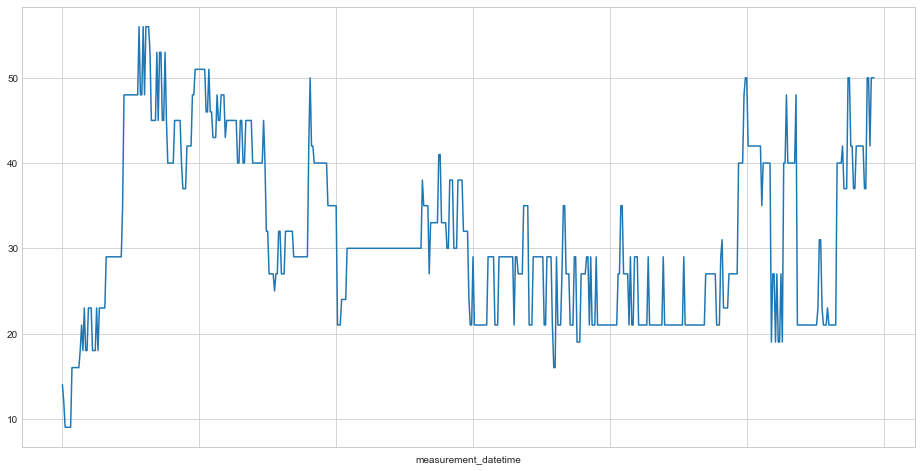

In [217]:
tempRelevantComponentsScore.plot(figsize=(16,9))

In [219]:
tempRelevantComponents.head()

,age,Glasgow coma scale,BP systolic,bodyTemperature_C,Oxygen saturation in Arterial blood,Oxygen concentration breathed,Leukocytes [#/volume] in Blood by Manual count,Potassium serum/plasma,Sodium serum/plasma,Total Bilirubin serum/plasma
measurement_datetime,,,,,,,,,,
2296 days 11:59:00,23.9,15,171,36.7,95,1,14.4,8.8,135,0.3
2296 days 12:49:00,23.9,15,116,36.7,100,1,14.4,8.8,135,0.3
2296 days 12:51:00,23.9,15,116,36.7,100,1,17.6,4,139,0.2
2296 days 13:49:00,23.9,15,136,36.7,96,0.6,17.6,4,139,0.2
2296 days 14:04:00,23.9,15,122,36.7,95,0.6,17.6,4,139,0.2
